In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir('../notebook_format')
from formats import load_style
load_style()

# h2o python API

In [3]:
os.chdir(path)

import h2o
%matplotlib inline
import pandas as pd                   
import matplotlib.pyplot as plt
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

# initialize h2o cluster, nthreads = -1 uses all possible cores,
# and max_mem_size stands for maximum memory size allowed
h2o.init( nthreads = -1, max_mem_size = 5 )



No instance found at ip and port: localhost:54321. Trying to start local jar...


JVM stdout: /var/folders/x3/zghnnw9x1nl2x4vsqd97kxym0000gn/T/tmpj8lduemm/h2o_ethen_started_from_python.out
JVM stderr: /var/folders/x3/zghnnw9x1nl2x4vsqd97kxym0000gn/T/tmpgtjs9kkl/h2o_ethen_started_from_python.err
Using ice_root: /var/folders/x3/zghnnw9x1nl2x4vsqd97kxym0000gn/T/tmpe7uru8_v


Java Version: java version "1.6.0_65"
Java(TM) SE Runtime Environment (build 1.6.0_65-b14-468-11M4833)
Java HotSpot(TM) 64-Bit Server VM (build 20.65-b04-468, mixed mode)


Starting H2O JVM and connecting: ................ Connection successful!


H2O cluster uptime:,1 seconds 764 milliseconds
H2O cluster version:,3.8.1.4
H2O cluster name:,H2O_started_from_python_ethen_ooq079
H2O cluster total nodes:,1
H2O cluster total free memory:,4.98 GB
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321
H2O Connection proxy:,None


In [5]:
covtype_df = h2o.import_file( path = os.path.abspath("covtype.full.csv") )


Parse Progress: [##################################################] 100%


In [6]:
# split the data 60 training, 20 validation, 20 test
train, valid, test = covtype_df.split_frame( [0.6, 0.2], seed = 1234 )

# prepare predictors and response columns
covtype_X = covtype_df.col_names[:-1]      
covtype_y = covtype_df.col_names[-1]
covtype_y

'Cover_Type'

In [7]:
# types of each column, h2o will automatically perform one-hot encoding
# with enum column
covtype_df.types

{'Aspect': 'int',
 'Cover_Type': 'enum',
 'Elevation': 'int',
 'Hillshade_3pm': 'int',
 'Hillshade_9am': 'int',
 'Hillshade_Noon': 'int',
 'Horizontal_Distance_To_Fire_Points': 'int',
 'Horizontal_Distance_To_Hydrology': 'int',
 'Horizontal_Distance_To_Roadways': 'int',
 'Slope': 'int',
 'Soil_Type': 'enum',
 'Vertical_Distance_To_Hydrology': 'int',
 'Wilderness_Area': 'enum'}

## Deep Learning 

walking through the [notebook](http://nbviewer.jupyter.org/github/h2oai/h2o-tutorials/blob/master/tutorials/deeplearning/deeplearning.ipynb).

In [8]:
covtype_model_v1 = H2ODeepLearningEstimator( 
    model_id = "covtype_v1", 
    epochs = 1, 
    variable_importances = True
)
covtype_model_v1.train( covtype_X, covtype_y, training_frame = train, validation_frame = valid )


deeplearning Model Build Progress: [##################################################] 100%


In [9]:
var_df = pd.DataFrame( 
    covtype_model_v1.varimp(), 
    columns = ["Variable", "Relative Importance", "Scaled Importance", "Percentage"] 
)
print(var_df.shape)
var_df.head(10)

(56, 4)


,Variable,Relative Importance,Scaled Importance,Percentage
0,Horizontal_Distance_To_Roadways,1.000000,1.000000,0.030341
1,Elevation,0.991453,0.991453,0.030081
2,Wilderness_Area.area_0,0.975858,0.975858,0.029608
3,Horizontal_Distance_To_Fire_Points,0.949475,0.949475,0.028808
4,Wilderness_Area.area_2,0.867460,0.867460,0.026319
5,Wilderness_Area.area_3,0.864351,0.864351,0.026225
6,Wilderness_Area.area_1,0.804178,0.804178,0.024399
7,Soil_Type.type_23,0.730862,0.730862,0.022175
8,Soil_Type.type_21,0.724360,0.724360,0.021977
9,Soil_Type.type_31,0.691037,0.691037,0.020966


Now we run another, smaller network and we let it stop automatically once the misclassification rate converges (specifically if the moving average of length 2 does not improve by at least 1% for 2 consecutive scoring events).

In [10]:
covtype_model_v2 = H2ODeepLearningEstimator(
    model_id = "covtype_v2", 
    hidden = [ 32, 32, 32 ],           # small network, runs faster
    epochs = 1000000,                  # hopefully converges earlier...
    score_validation_samples = 10000,  # sample the validation dataset (faster)
    stopping_rounds = 2,
    stopping_metric = "misclassification", # alternatives: "MSE","logloss","r2"
    stopping_tolerance = 0.01
)
covtype_model_v2.train( covtype_X, covtype_y, training_frame = train, validation_frame = valid )


deeplearning Model Build Progress: [##################################################] 100%


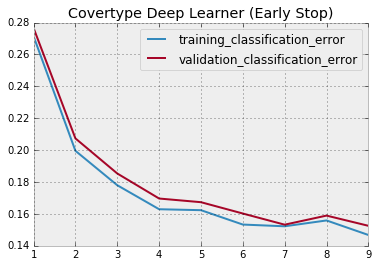

In [11]:
# we can visualize the scoring history
cov_v2_df = covtype_model_v2.scoring_history()
plt.plot( cov_v2_df['training_classification_error'], label = "training_classification_error" )
plt.plot( cov_v2_df['validation_classification_error'], label = "validation_classification_error" )
plt.title("Covertype Deep Learner (Early Stop)")
plt.legend()
plt.show()

We can see that the test set's number is fairly in line with our validation results from the graph.

In [12]:
pred = covtype_model_v2.predict(test).as_data_frame( use_pandas = True )
test_actual = test.as_data_frame( use_pandas = True )['Cover_Type']
( test_actual == pred['predict'] ).mean()


deeplearning prediction Progress: [##################################################] 100%


0.84879159158123452

## H2O Deep Learning Tips & Tricks


### Activation Functions

While sigmoids have been used historically for neural networks, H2O Deep Learning implements Tanh, a scaled and shifted variant of the sigmoid which is symmetric around 0. Since its output values are bounded by -1..1, the stability of the neural network is rarely endangered. However, the derivative of the tanh function is always non-zero and back-propagation (training) of the weights is more computationally expensive than for rectified linear units, or Rectifier, which is max(0,x) and has vanishing gradient for x<=0, leading to much faster training speed for large networks and is often the fastest path to accuracy on larger problems. In case you encounter instabilities with the Rectifier (in which case model building is automatically aborted), try a limited value to re-scale the weights: max_w2=10. The Maxout activation function is computationally more expensive, but can lead to higher accuracy. It is a generalized version of the Rectifier with two non-zero channels. In practice, the Rectifier (and RectifierWithDropout, see below regarding Dropout) is the most versatile and performant option for most problems.

### Generalization Techniques

L1 and L2 penalties can be applied by specifying the l1 and l2 parameters. Intuition: L1 lets only strong weights survive (constant pulling force towards zero), while L2 prevents any single weight from getting too big. Dropout has recently been introduced as a powerful generalization technique, and is available as a parameter per layer, including the input layer. input_dropout_ratio controls the amount of input layer neurons that are randomly dropped (set to zero), while hidden_dropout_ratios are specified for each hidden layer. The former controls overfitting with respect to the input data (useful for high-dimensional noisy data), while the latter controls overfitting of the learned features. Note that hidden_dropout_ratios require the activation function to end with ...WithDropout.

### Early stopping and optimizing for lowest validation error

By default, Deep Learning training stops when the stopping_metric does not improve by at least stopping_tolerance (0.01 means 1% improvement) for stopping_rounds consecutive scoring events on the training (or validation) data. By default, overwrite_with_best_model is enabled and the model returned after training for the specified number of epochs (or after stopping early due to convergence) is the model that has the best training set error (according to the metric specified by stopping_metric), or, if a validation set is provided, the lowest validation set error. For early stopping on a predefined error rate on the training data (accuracy for classification or MSE for regression), specify classification_stop or regression_stop.

### Categorical Data

For categorical data, a feature with K factor levels is automatically one-hot encoded (horizontalized) into K-1 input neurons. Hence, the input neuron layer can grow substantially for datasets with high factor counts. In these cases, it might make sense to reduce the number of hidden neurons in the first hidden layer, such that large numbers of factor levels can be handled. In the limit of 1 neuron in the first hidden layer, the resulting model is similar to logistic regression with stochastic gradient descent, except that for classification problems, there's still a softmax output layer, and that the activation function is not necessarily a sigmoid (Tanh). If variable importances are computed, it is recommended to turn on use_all_factor_levels (K input neurons for K levels). The experimental option max_categorical_features uses feature hashing to reduce the number of input neurons via the hash trick at the expense of hash collisions and reduced accuracy.

### Reproducibility

Every run of DeepLearning results in different results since multithreading is done via Hogwild! that benefits from intentional lock-free race conditions between threads. To get reproducible results for small datasets and testing purposes, set reproducible=True and set seed=1337 (pick any integer). This will not work for big data for technical reasons, and is probably also not desired because of the significant slowdown (runs on 1 core only).

### Scoring on Training/Validation Sets During Training

The training and/or validation set errors can be based on a subset of the training or validation data, depending on the values for score_validation_samples (defaults to 0: all) or score_training_samples (defaults to 10,000 rows, since the training error is only used for early stopping and monitoring).

Note that the default value of score_duty_cycle=0.1 limits the amount of time spent in scoring to 10%, so a large number of scoring samples won't slow down overall training progress too much, but it will always score once after the first MapReduce iteration, and once at the end of training.

Stratified sampling of the validation dataset can help with scoring on datasets with class imbalance. Note that this option also requires balance_classes to be enabled.

## Ensemble Tree

walking through the [notebook](https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/gbm-randomforest/GBM_RandomForest_Example.ipynb).

In [38]:
gbm_v3 = H2OGradientBoostingEstimator(
    ntrees = 30,
    learn_rate = 0.3,
    max_depth = 10,
    sample_rate = 0.7,
    col_sample_rate = 0.7,
    stopping_rounds = 2,
    stopping_tolerance = 0.01,
    score_each_iteration = True,
    model_id = "gbm_covType_v3",
    seed = 2000000
)
gbm_v3.train( covtype_X, covtype_y, training_frame = train, validation_frame = valid )


gbm Model Build Progress: [##################################################] 100%


In [39]:
rf_v2 = H2ORandomForestEstimator(
    model_id = "rf_covType_v2",
    ntrees = 200,
    max_depth = 30,
    stopping_rounds = 2,
    stopping_tolerance = 0.01,
    score_each_iteration = True,
    seed = 3000000
)
rf_v2.train( covtype_X, covtype_y, training_frame = train, validation_frame = valid )


drf Model Build Progress: [##################################################] 100%


In [42]:
final_rf_predictions = rf_v2.predict(test)
( final_rf_predictions['predict'] == test['Cover_Type'] ).as_data_frame( use_pandas = True ).mean()

predict    0.953897
dtype: float64

Notes.

1. In a production setting where fine-grain accuracy is beneficial, it is common to set the learn rate to a very small number, such as 0.01 or smaller, and add trees to match. 
2. Use of early stopping is very powerful in allowing the setting of a low learning rate and the building as many trees as needed until the desired convergence is met.

## Grid Search 

1. [python booklet](https://github.com/ethen8181/machine-learning/blob/master/h2o/Python_booklet.pdf).
2. [Getting information about the grid search model workflow](https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/GridSearch.md#random-hyper-parmameter-grid-search-example).

In [95]:
ntrees_opt = [ 5, 15 ]
max_depth_opt = [ 2, 4 ]
learn_rate_opt = [ 0.1, 0.2 ]
hyper_parameters = {
    "ntrees": ntrees_opt, 
    "max_depth": max_depth_opt,
    "learn_rate": learn_rate_opt
}
# you can pass in additional search_criteria for random search; e.g.
# search_criteria = { 'strategy': 'RandomDiscrete', 'max_models': 3 }
gs = H2OGridSearch( 
    model = H2OGradientBoostingEstimator( distribution = "multinomial" ), 
    hyper_params = hyper_parameters,
    grid_id = "grid1"
)

In [59]:
gs.train( x = covtype_X, y = covtype_y, training_frame = train, validation_frame = valid )


gbm Grid Build Progress: [##################################################] 100%


Sort the models in the grid space by a metric , 'mse', 'r2', 'logloss'; obtain the model id of the model with the best score.

In [80]:
best_model_id = gs.sort_by( metric = "logloss", increasing = True )['Model Id'][0]
best_model = h2o.get_model(best_model_id)
best_model.predict(train)

predict,class_1,class_2,class_3,class_4,class_5,class_6,class_7
class_1,0.75132,0.21922,0.00587509,0.00505035,0.00575674,0.00586757,0.00691034
class_1,0.827656,0.127404,0.00594402,0.00506221,0.0059703,0.00593174,0.0220315
class_1,0.884232,0.091247,0.0050751,0.00435566,0.00504936,0.00507264,0.00496839
class_2,0.0305834,0.929408,0.0069238,0.00529501,0.0114211,0.0100011,0.00636765
class_1,0.876184,0.0838305,0.0053489,0.00459064,0.00532177,0.00534631,0.0193781
class_2,0.137774,0.820198,0.00634637,0.00545548,0.017187,0.00633824,0.00670102
class_1,0.867821,0.0943964,0.00534922,0.00459092,0.00532209,0.00534663,0.017174
class_2,0.178554,0.753593,0.00717514,0.00611425,0.0398143,0.00785674,0.00689261
class_2,0.429951,0.51107,0.00948697,0.00818268,0.0191852,0.0127544,0.00937016
class_2,0.104472,0.821414,0.00616151,0.00532503,0.0501017,0.00622306,0.0063027


In [94]:
# best_model.model_performance().confusion_matrix()

In [82]:
gs.get_hyperparams(best_model_id)

Hyperparameters: [ntrees, max_depth, learn_rate]


[15, 4, 0.2]